# Frequency analysis

## Mass - spring system with damper

First we computed the solution in the time domain, doing a FFT on that to see the frequency behaviour. Adding a damping constant c different from zero, adds some frequencies around 0.

In [ ]:
using LinearAlgebra
using DifferentialEquations
using Plots
using FFTW

theoretical peak frequency: 1.0


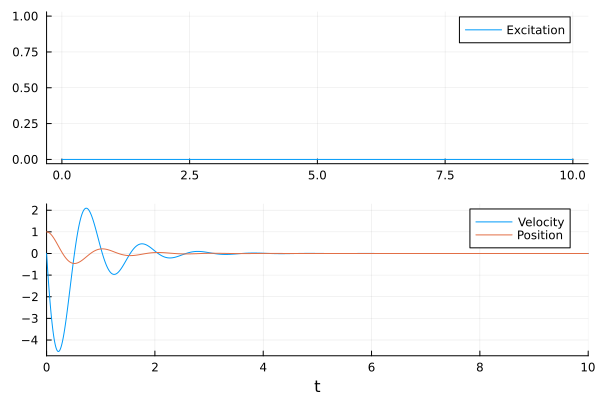

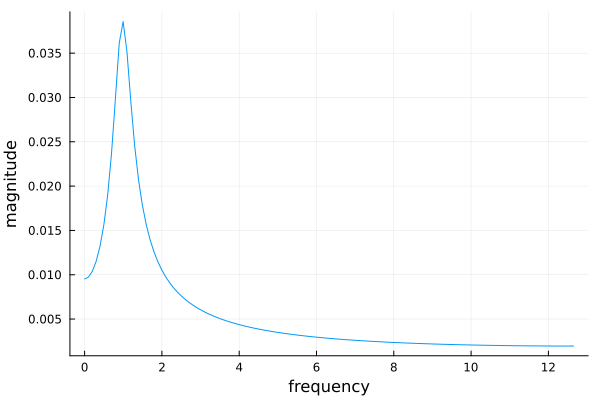

In [30]:
# mass of rigid body
m = 1
# damping constant
c = 3 # With this c > 0, the peak at 1 Hz is still there, but there are also some other frequencies appearing
# spring constant
k = 4*pi^2

peak_freq = sqrt(k/m)/(2*pi)
println(string("theoretical peak frequency: ", peak_freq))

# external force
function Fext(t)
    return 0
#     return exp(-(t-6)^2/0.01)
end

function system(du,u,p,t)
    # solve m \ddot{u} + c \dot{u} + k u = Fext
   ddu = -(c/m)*du -(k/m)*u + Fext(t) 
end

# Governing equation
# m*y'' + c*y' + k*y = Fext

# Initial values
u0 = 1.0                               
v0 = 0.0
# Set time span
endTime = 10.0
tspan = (0.0, endTime)  

N = 2^8
timestep = endTime/(N-1)  
sampFreq = 1/timestep        

# Define ODE problem to be solved and solve it
prob = SecondOrderODEProblem(system,v0,u0,tspan)
sol = solve(prob, adaptive = false, dt = timestep)

# Plot the external force
tvec = Vector(0.:0.01:10.)
fvec = Fext.(tvec)
p1 = Plots.plot(tvec,fvec,label="Excitation")

# Plot solution of equation
Plots.plot(sol,vars=1,label="Velocity")
p2 = Plots.plot!(sol,vars=2,label="Position")

display(Plots.plot(p1,p2,layout=(2,1)))

# Extract position
pos = [x[2] for x in sol[:]]
FT = fft(pos);

# Plot magnitude of fft (only positive frequencies)
fVals = sampFreq .* (0:1:N/2-1) ./ N;
mag = abs.(FT[1:length(fVals)]) .* 1/N
magPlot = Plots.plot(fVals, mag, label="")
xlabel!("frequency")
ylabel!("magnitude")

Using another approach, the Laplace transform of the equation was calculated and plotted directly. For the same parameters, we do indeed get a similar result!

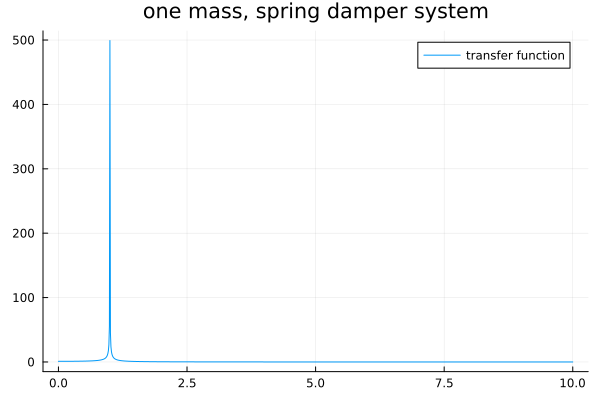

In [27]:
m = 1 
k = 1
c = 0
F = 10
v0 = 0.0 
x0 = 1.0 
w0 = sqrt(k/m) #natural frequency in radians, should now again be one

# model in frequency domain
H(w) = sqrt((real((m*v0 + x0)/(-w^2*m + im*w*c + k)))^2 + (imag((m*v0 + x0)/(-w^2*m + im*w*c + k))^2))

# results
w = range(0, 10, 1000)
s = w .* 1im
display(Plots.plot(w, H, title="one mass, spring damper system", label="transfer function")) #typically for a graphical visualisation, you only visualise the positive frequency values
#scale the vertical axis with the number of time samples: only needed if you go from the answer in the time domain to the answer in the frequency domain through the FFT.

## Two masses and a spring
Same method as before, calculating the solution in time domain and doing FFT on that result.

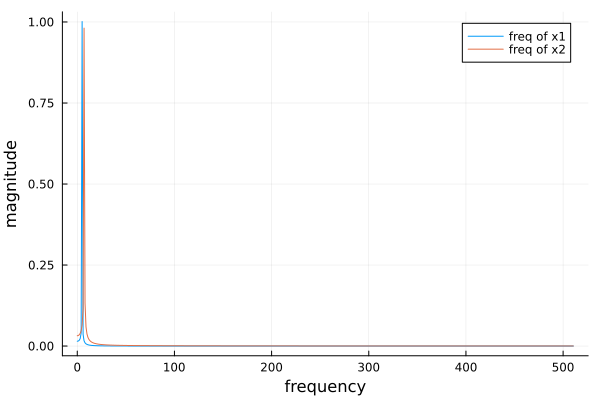

In [26]:
# mass of rigid bodies
m1 = 10
m2 = 10
# damping constant (same for the two springs)
c = 0
# spring constant (same for the two springs)
k = 1000

# external force
function Fext(t)
    # return sin(1*t)
    return 0
end

function system!(ddu, du, u, p, t)
    ddu[1] = -(k/m)*u[1] + Fext(t)
    ddu[2] = -(2*k/m)*u[2] + Fext(t)
end


# Initial values
u0 = [2.0, 2.0]                              
v0 = [0.0, 0.0]
# Set time span
endTime = 1
tspan = (0.0, endTime)  

N = 2^10
timestep = endTime/(N-1)  
sampFreq = 1/timestep        

# Define ODE problem to be solved and solve it
prob = SecondOrderODEProblem(system!, v0, u0, tspan)
sol = solve(prob, adaptive = false, dt = timestep)

# Plot time solution
# plot(sol,vars=1,label="Vel x-direction") 
# p1 = plot!(sol,vars=3,label="Pos x-direction")

# plot(sol,vars=2,label="Vel y-direction") 
# p2 = plot!(sol,vars=4,label="Pos y-direction")

# p3 = plot(sol,vars=(3,4),label="x(t) and y(t)")
# xlabel!("x(t)") 
# ylabel!("y(t)")

# plot(p1,p2,p3,layout=(3,1))

# Extract position
x1 = [a[3] for a in sol.u[:]]
F1 = fft(x1);
x2 = [a[4] for a in sol.u[:]]
F2 = fft(x2);

# Plot magnitude of fft (only positive frequencies)
fVals = sampFreq .* (0:1:N/2-1) ./N;
mag = abs.(F1[1:length(fVals)]) ./N
magPlot = plot(fVals, mag, label="freq of x1")
xlabel!("frequency")
ylabel!("magnitude")

mag = abs.(F2[1:length(fVals)]) .* 1/N
plot!(fVals, mag, label="freq of x2")

Again using the Laplace transform to make the frequency 

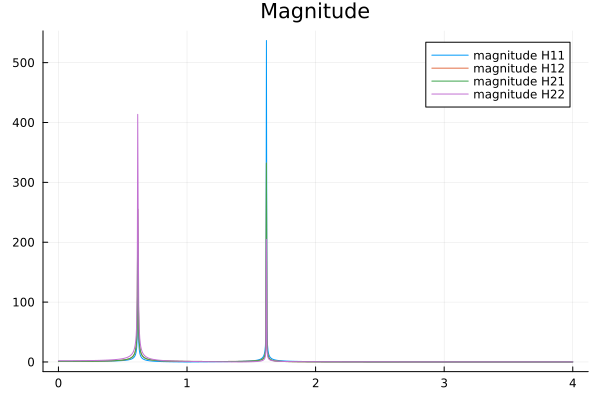

w1 = 0.6180339887498948, w2 = 1.618033988749895


In [39]:
m1 = 1.0; m2 = 1.0;
k1 = 1.0; k2 = 1.0;
c1 = 0.0; c2 = 0.0;
f1 = 1.0; f2 = 1.0;

M = [m1 0
     0  m2]
C = [c1+c2 -c2 
     -c2    c2]
K = [k1+k2 -k2 
     -k2    k2]
F = [f1
     f2]

H(s) = inv(((s^2*M) + (s*C) + K)) #transfer function, size:2x2
#X(w) = H(w)*F(w)
omega = range(0, 4, length=1000)
s = im*omega

# Results
# extract information of the transfer between the force and the displacements 
# for each element plot the magnitude and phase 
# X1 = H11*F1 + H12*F2 = H[1,:]*F
# X2 = H21*F1 + H22*F2 = H[2,:]*F

transfer = zeros((1000,2,2))*im #intitialisation 
for l in 1:1000
    transfer[l,:,:] = H(s[l]) #get the transfer function for each s defined above 
end
    
p1 = Plots.plot(omega, abs.(transfer[:,1,1]), title="Magnitude", label="magnitude H11")
Plots.plot!(omega, abs.(transfer[:,1,2]), label="magnitude H12")
Plots.plot!(omega, abs.(transfer[:,2,1]), label="magnitude H21")
Plots.plot!(omega, abs.(transfer[:,2,2]), label="magnitude H22")

# Plot the phase, if you want
# p2 = Plots.plot(omega, angle.(transfer[:,1,1]), title="Phase", label="phase H11")
# Plots.plot!(omega, angle.(transfer[:,1,2]), label="phase H12")
# Plots.plot!(omega, angle.(transfer[:,2,1]), label="phase H21")
# Plots.plot!(omega, angle.(transfer[:,2,2]), label="phase H22")
display(Plots.plot(p1))

# Get the natural frequencies -> you'll have two: fundamental mode of vibration and second mode of vibration 
# the natural frequencies are the zeros of the characteristic equation 
w1 = sqrt((3-sqrt(5))/2);
w2 = sqrt((3+sqrt(5))/2);
println(String("w1 = $(w1), w2 = $(w2)"))

## Modeling of the bus door
Now we get to the fun part: the bus door. Below is the code to model the door using gmsh.

In [13]:
# import Gmsh: gmsh 
# The usual way doesn't work so we had to install the gmsh SDK locally and include it by referring to the current path
include("src/gmsh/lib/gmsh.jl")
using GR 
using LinearAlgebra
using Plots

gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.add("t1")
lc = 1e-1
gmsh.model.geo.addPoint(0, 0, 0, lc, 1)
gmsh.model.geo.addPoint(1., 0,  0, lc, 2)
gmsh.model.geo.addPoint(1., 2., 0, lc, 3)
gmsh.model.geo.addPoint(0, 2., 0, lc, 4)
gmsh.model.geo.addLine(1, 2, 5)
gmsh.model.geo.addLine(2, 3, 6)
gmsh.model.geo.addLine(3, 4, 7)
gmsh.model.geo.addLine(4, 1, 8)
gmsh.model.geo.addCurveLoop([5, 6, 7, 8], 9)
gmsh.model.geo.addPlaneSurface([9], 10)
gmsh.model.setPhysicalName(2, 11, "My surface")
gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)
# Write mesh to file for further processing 
if (false) gmsh.write("door.msh") end 
# Visualize mesh through the GUI 
if (false) gmsh.fltk.run() end 

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 5 (Line)
Info    : [ 30%] Meshing curve 6 (Line)
Info    : [ 50%] Meshing curve 7 (Line)
Info    : [ 80%] Meshing curve 8 (Line)
Info    : Done meshing 1D (Wall 0s, CPU 0s)
Info    : Meshing 2D...
Info    : Meshing surface 10 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.015666s, CPU 0s)
Info    : 273 nodes 548 elements


Next, the K, C, M and F matrices or vectors need to be constructed from the mesh info.

In [57]:
# Define the source function that operates on the door
sourcefunction(x,y) = exp(-((x-0.5)^2 + (y-1)^2)/0.01);

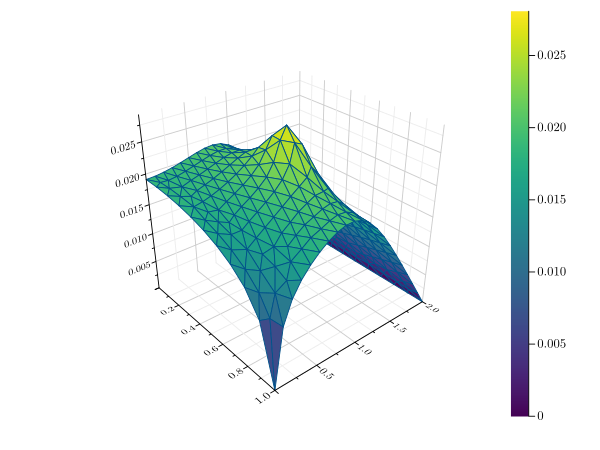

In [58]:
## RETRIEVE MODEL INFO -------------------------------------------------------------------------------
nodeIds, nodeCoord, _ = gmsh.model.mesh.getNodes();
Nnodes = length(nodeIds)

# Sort the node coordinates by ID, such that Node one sits at row 1
toSort = [nodeIds nodeCoord[1:3:end] nodeCoord[2:3:end]];
sortedNodes = sortslices(toSort, dims = 1);
nodeIds = sortedNodes[:,1];
nodeX = sortedNodes[:,2];
nodeY = sortedNodes[:,3];

# Retrieve element information
elemTypes, elemIds, elemConn = gmsh.model.mesh.getElements(2);
elemIds = elemIds[1]; elemConn = elemConn[1];
Nelem = length(elemIds);


## MAIN METHOD -------------------------------------------------------------------------------------
#  Construct global matrices
K = zeros(Nnodes, Nnodes);
F = zeros(Nnodes, 1);
M = zeros(Nnodes, Nnodes);

fvalues = map(sourcefunction, nodeX, nodeY)

for elemI in 1:Nelem
    # Retrieve 
    node1ID = elemConn[3*(elemI-1)+1]
    node2ID = elemConn[3*(elemI-1)+2]
    node3ID = elemConn[3*elemI]

    x1 = nodeX[node1ID]; x2 = nodeX[node2ID]; x3 = nodeX[node3ID];
    y1 = nodeY[node1ID]; y2 = nodeY[node2ID]; y3 = nodeY[node3ID];
    
    # Calculate area
    area = abs(x1*(y2-y3) + x2*(y3-y1) + x3*(y1-y2))/2.;

    # Calculate local f
    f = area/3 * [fvalues[node1ID]; fvalues[node2ID]; fvalues[node3ID]];

    # Solve the local linear system of the elements to find the a_i, b_i, c_i
    # of the local v_i functions
    Vcoef = [[x1; x2; x3] [y1; y2; y3] [1; 1; 1]] \ I;

    # Calculate K_elem
    Vcoef[3,:] .= 0;
    Kelem = area*(transpose(Vcoef)*Vcoef);

    # Assembly from local to global
    for i = 1:3
        globalI = elemConn[3*(elemI-1)+i]
        F[globalI] += f[i];
        # Add local M contribution to global M
        # M_e = (area/3) * I(3)
        M[globalI, globalI] += area/3 
        for j = 1:3
            globalJ = elemConn[3*(elemI-1)+j]
            K[globalI, globalJ] += Kelem[i,j]
        end
    end
end


# IMPOSE BOUNDARY CONDITIONS ---------------------------------------------------------------------------------------------

# We impose that the right bottom point of the door is fixed, as is the entire upper bar.

# nodeId1, _, _ = gmsh.model.mesh.getNodes(0,1) # Left bottom point
nodeId2, _, _ = gmsh.model.mesh.getNodes(0,2) # Right bottom point
nodeId3, _, _ = gmsh.model.mesh.getNodes(0,3) # Right upper point
nodeId4, _, _ = gmsh.model.mesh.getNodes(0,4) # Left upper point
# nodeId5, _, _ = gmsh.model.mesh.getNodes(1,5) # Bottom line
# nodeId6, _, _ = gmsh.model.mesh.getNodes(1,6) # Right line
nodeId7, _, _ = gmsh.model.mesh.getNodes(1,7) # Upper line
# nodeId8, _, _ = gmsh.model.mesh.getNodes(1,8) # Left line
boundNodeIds = union(nodeId2,nodeId3,nodeId4,nodeId7)
K[boundNodeIds,:] .= 0;
K[boundNodeIds,boundNodeIds] = Diagonal(ones(size(boundNodeIds)))
F[boundNodeIds] .= 0;


## FINAL CALCULATIONS ----------------------------------------------------------------------------------------------------
# Compute damping matrix
# Constant for the damping matrix
ALPHA = 1.;
C = ALPHA .* M;

# Calculating and plotting the static solution
plotTrue = true;
if (plotTrue)
    u = K\F
    trisurf(nodeX, nodeY, u)
end

## Analyzing the frequency behaviour of the displacement
Construct the system matrices to do the frequency analysis

In [48]:
using ControlSystems

In [63]:
N = Nnodes;
A = zeros(2*N, 2*N)
B = zeros(2*N, N)
Csys = zeros(N, 2*N)

A[1:N, N+1:2*N] = I(N);
A[N+1:2*N, 1:N] = -M\K; # = -inv(M)*K
A[N+1:2*N, N+1:2*N] = -M\C;

B[N+1:2*N, 1:N] = M\I; # = inv(M)

Csys[1:N, 1:N] = I(N);

sys = ss(A,B,Csys,0);

Investigate stability of the system

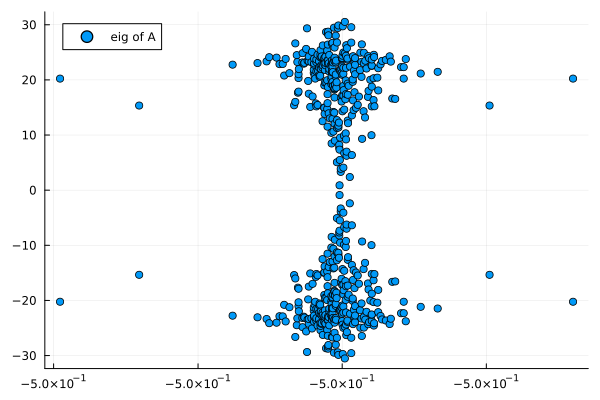

In [66]:
# Plot eigenvalues of A = poles of the system
# If all eigenvalues have a real part < 0, the system is stable
eigA = eigvals(A);
Plots.plot(real(eigA),imag(eigA), seriestype=:scatter, label="eig of A")

Look at the displacement over time of the left bottom point of the door. Here we see that the displacement does not diverge and returns to some stable value.

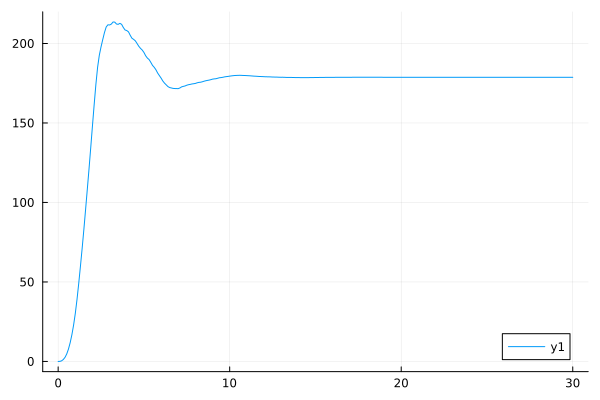

In [64]:
# Simulate system for some input
sourcefunction(x,y) = x+y
fvalues = map(sourcefunction, nodeX, nodeY)

t = 0:0.1:30;
u = zeros(length(fvalues), length(t))
for i = 1:length(t)
    u[:,i] = fvalues
end

y, t, x, u = lsim(sys,u,t);
nodeId, _, _ = gmsh.model.mesh.getNodes(0,1) # Left bottom point

Plots.plot(t,transpose(y[nodeId,:]))
